In [17]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from collections import defaultdict
import os
import json
from matplotlib import pyplot as plt

from src.dataset_handling import TextClassificationDataset
from src.utils import get_activations_and_labels
from src.sparse_probes import ClassificationProbe

In [2]:
model_url = "EleutherAI/pythia-14m"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)

num_hookpoints = model.config.num_hidden_layers
hookpoints = [hookpoint_name.replace('$', str(i)) for i in range(num_hookpoints)]
input_size = model.config.intermediate_size

data_path = 'data/split/tedtalks_test.tsv'
dataset = TextClassificationDataset.from_tsv(data_path)

In [3]:
model_folder = f'models/sparse_probes/{model_name}'

probes = defaultdict(dict)

for name in os.listdir(model_folder):
    for hookpoint in hookpoints:

        with open(f'{model_folder}/{name}/{hookpoint}.json', 'r') as file:
            meta_data = json.load(file)

        probe = ClassificationProbe(input_size, device)
        probe.load_state_dict(torch.load(f'{model_folder}/{name}/{hookpoint}.pt', weights_only=True))

        probes[meta_data['reg_lambda']][hookpoint] = probe

In [13]:
num_sentences = 1000
text_batch, label_batch = dataset[:num_sentences]

activations, labels = get_activations_and_labels(text_batch, label_batch, model, hookpoints, tokenizer, device)

In [21]:
accuracy = defaultdict(dict)

for reg_lambda in probes.keys():
    for hookpoint in hookpoints:

        preds = (probes[reg_lambda][hookpoint](activations[hookpoint].to(device)) > 0.5).float()

        acc = (preds == labels).sum() / len(preds)
        accuracy[reg_lambda][hookpoint] = acc.item()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_27436\3067483336.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(hookpoints, rotation=45, ha='right')
C:\Users\Bruger\AppData\Local\Temp\ipykernel_27436\3067483336.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


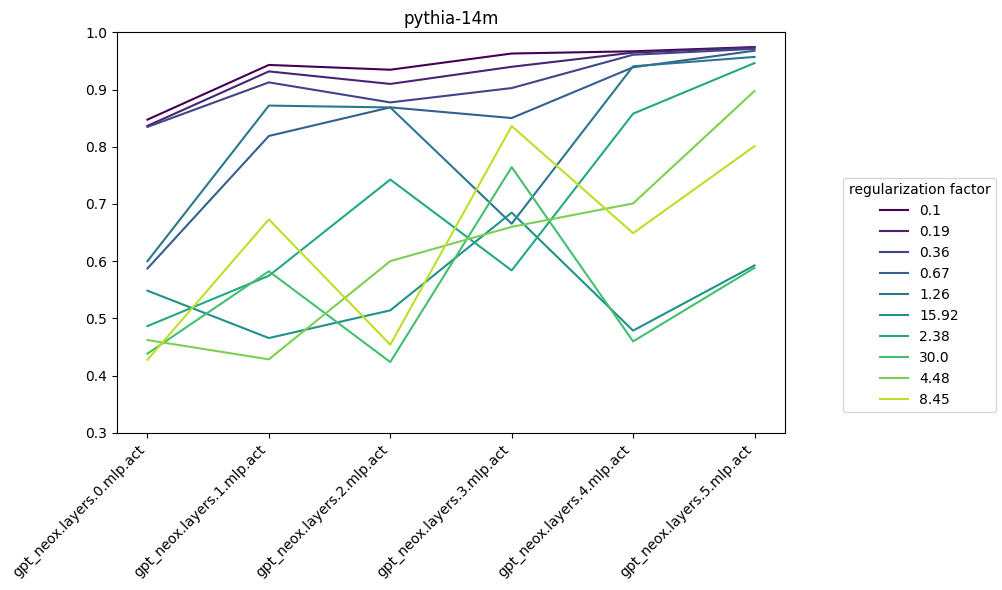

In [26]:
# Specify the number of colors you need
num_colors = len(probes.keys())

# Choose a colormap
cmap = plt.cm.viridis  # You can use any colormap, e.g., 'plasma', 'coolwarm', etc.

# Generate a list of evenly spaced colors
colors = [cmap((i / num_colors)) for i in range(num_colors)]


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title(model_name)
ax.set_xticklabels(hookpoints, rotation=45, ha='right')

for (reg_lambda, acc), color in zip(accuracy.items(), colors):

    ax.plot(acc.keys(), acc.values(), color=color, label=round(float(reg_lambda), 2))

ax.set_ylim(0.30, 1)
fig.legend(loc='right', title='regularization factor')
fig.tight_layout(rect=[0, 0, 0.8, 1])
fig.show()

fig.savefig(f'figures/sparse_probes/{model_name}.png', dpi=300)